# General libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from pymatgen.core import periodic_table
import pymatgen.io.cif as cif
import pymatgen.analysis.ewald as ewald

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

---

In [7]:
# here will be a part for data obtaining with materials project REST API

---

# Dataset normalization

In [8]:
df = pd.read_csv('Var_01.csv')
df.sample(2)

# all need is POSCAR as input for future engineernig
df.drop(['energy_per_atom', 'formation_energy_per_atom', 'volume', 'nsites', 'unit_cell_formula', 'pretty_formula', 'is_hubbard', 'elements', 
 'nelements', 'e_above_hull', 'hubbards', 'is_compatible', 'spacegroup', 'task_ids', 'band_gap', 'density', 
 'icsd_id', 'icsd_ids',  'total_magnetization', 'material_id', 'oxide_type', 'tags', 'piezo', 'diel', 'full_formula'], axis='columns', inplace=True)
df.dropna(inplace=True)

In [9]:
# extract bulk moduli
df['bulk'] = df.elasticity.apply(lambda x: eval(x)['K_VRH'])
df

,energy,cif,elasticity,bulk
2,-15.580602,# generated using pymatgen\r\ndata_FeAg3\r\n_s...,"{'G_Reuss': -15.0, 'G_VRH': 8.0, 'G_Voigt': 32...",133.0
4,-11.293552,# generated using pymatgen\r\ndata_AlFe\r\n_sy...,"{'G_Reuss': 133.0, 'G_VRH': 75.0, 'G_Voigt': 1...",85.0
5,-41.981392,# generated using pymatgen\r\ndata_AlFe2\r\n_s...,"{'G_Reuss': 60.0, 'G_VRH': 60.0, 'G_Voigt': 61...",117.0
7,-64.628769,# generated using pymatgen\r\ndata_Al6Fe\r\n_s...,"{'G_Reuss': 53.0, 'G_VRH': 56.0, 'G_Voigt': 58...",106.0
9,-40.645991,# generated using pymatgen\r\ndata_Al3Fe\r\n_s...,"{'G_Reuss': 51.0, 'G_VRH': 53.0, 'G_Voigt': 55...",125.0
...,...,...,...,...
550,-49.071885,# generated using pymatgen\r\ndata_YFe5\r\n_sy...,"{'G_Reuss': 67.0, 'G_VRH': 68.0, 'G_Voigt': 68...",105.0
563,-25.278117,# generated using pymatgen\r\ndata_Zn13Fe\r\n_...,"{'G_Reuss': 41.0, 'G_VRH': 42.0, 'G_Voigt': 43...",86.0
566,-51.810017,# generated using pymatgen\r\ndata_ZrFe2\r\n_s...,"{'G_Reuss': 71.0, 'G_VRH': 72.0, 'G_Voigt': 73...",147.0
568,-51.939510,# generated using pymatgen\r\ndata_Zr2Fe\r\n_s...,"{'G_Reuss': 30.0, 'G_VRH': 32.0, 'G_Voigt': 35...",124.0


In [10]:
# predicted value
pred_val = 'bulk'

---

# Data processing

In [11]:
def get_elem_props(elem):
    elem_props = {}
    elem_props['Z'] = periodic_table.Element(elem).Z
    elem_props['X'] = periodic_table.Element(elem).X
    elem_props['oxidation_states'] = periodic_table.Element(elem).oxidation_states
    elem_props['row'] = periodic_table.Element(elem).row
    elem_props['group'] = periodic_table.Element(elem).group
    elem_props['atomic_mass'] = periodic_table.Element(elem).atomic_mass
    elem_props['atomic_radius'] = periodic_table.Element(elem).atomic_radius
    elem_props['electrical_resistivity'] = periodic_table.Element(elem).electrical_resistivity
    elem_props['velocity_of_sound'] = periodic_table.Element(elem).velocity_of_sound
    elem_props['molar_volume'] = periodic_table.Element(elem).density_of_solid
    elem_props['thermal_conductivity'] = periodic_table.Element(elem).thermal_conductivity
    elem_props['melting_point'] = periodic_table.Element(elem).melting_point
    elem_props['average_ionic_radius'] = periodic_table.Element(elem).average_ionic_radius
    elem_props['average_cationic_radius'] = periodic_table.Element(elem).average_cationic_radius
    elem_props['average_anionic_radius'] = periodic_table.Element(elem).average_anionic_radius

    return elem_props

# Functions for the futures extracting

Extract pymatgen structure object from cif file as string

In [12]:
def get_struct(file_cif):
    imported_cif = cif.CifParser.from_string(file_cif) #; print(imported_cif)
    struct = imported_cif.get_structures()[0] #; print(struct)
    return struct

Function on Ewald summation as the convolutional layer for crystalline graph

In [13]:
def ewald_sum(struct):
    ew = ewald.EwaldSummation(struct, 
                         real_space_cut=None, 
                         recip_space_cut=None, 
                         eta=None, 
                         acc_factor=12.0, 
                         w=0.7071067811865475, 
                         compute_forces=False)
    
    return ew.total_energy

Charged structure is mandatory for Ewald summation procedure

We want to replace simple atomic oxidation states by another properties

In [14]:
def get_ox_dict(struct, prop):
    ox_dict={}
    for i in struct.species:
        try:
            ox_dict[str(i)] = round(get_elem_props(i)[prop])
        except Exception as e:
            ox_dict[str(i)] = np.nan
            print(e)
    return ox_dict

Then we need to get pymatgen.core.Structure obj. as the charged structure

In [15]:
def get_charged_struct(file_cif, ox_dict):
    imported_cif = cif.CifParser.from_string(file_cif)
    struct = imported_cif.get_structures()[0]
    try:
        struct.add_oxidation_state_by_element(ox_dict)
        return struct
    except Exception as e:
        print(e)
        return np.nan

Finally we can summarize previous functions to get a result of Ewald summation from one line of dataset

In [16]:
def get_ew(file_cif, p):
    struct = get_struct(file_cif)
    ox_dict = get_ox_dict(struct, p) #; print(ox_dict)
    charged_struct = get_charged_struct(file_cif, ox_dict) #; print(charged_struct)
    try:
        ew = ewald_sum(charged_struct) #; print(ew)
        return (ew*-1)
    except Exception as e:
        print(e)
        return np.nan

# Prepare raw futures

In [17]:
props = ['Z', 'X', 'row', 'group', 'atomic_mass', 'atomic_radius', 'thermal_conductivity', 'melting_point'] 

d = df.copy()

# instantiate progress
total = d.shape[0]

p_counter = 0
p_len = len(props) #; print(p_len)

for p in props:
    df_processed = pd.DataFrame()
    tmp = {}
    p_counter += 1
    progress = 0
    
    # cs corresponds to single cif as string
    for cs in d['cif']:
        f = get_ew(cs, p)
        tmp[p] = f
        df_processed = df_processed.append([tmp])
        
        # update progress
        progress += 1
        print(f'Property: {p_counter}/{p_len}, Progress: {progress}/{total} ', end='\r')
    
    d[p] = df_processed.values

d

C:\Users\User\Anaconda3\envs\Pymatgen\lib\site-packages\pymatgen\io\cif.py:1121: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


,energy,cif,elasticity,bulk,Z,X,row,group,atomic_mass,atomic_radius,thermal_conductivity,melting_point
2,-15.580602,# generated using pymatgen\r\ndata_FeAg3\r\n_s...,"{'G_Reuss': -15.0, 'G_VRH': 8.0, 'G_Voigt': 32...",133.0,57852.650775,129.645511,734.360152,3432.926361,300836.795955,102.338288,4.179167e+06,6.265616e+07
4,-11.293552,# generated using pymatgen\r\ndata_AlFe\r\n_sy...,"{'G_Reuss': 133.0, 'G_VRH': 75.0, 'G_Voigt': 1...",85.0,6565.698759,66.955974,206.240223,1875.162860,29827.463753,16.738993,4.437626e+05,3.242468e+07
5,-41.981392,# generated using pymatgen\r\ndata_AlFe2\r\n_s...,"{'G_Reuss': 60.0, 'G_VRH': 60.0, 'G_Voigt': 61...",117.0,25192.936144,212.452261,711.473010,5187.643400,115432.296957,53.113065,1.082677e+06,1.235264e+08
7,-64.628769,# generated using pymatgen\r\ndata_Al6Fe\r\n_s...,"{'G_Reuss': 53.0, 'G_VRH': 56.0, 'G_Voigt': 58...",106.0,26321.621835,465.916900,1148.850214,17909.716720,116162.691009,116.479225,5.524227e+06,1.331458e+08
9,-40.645991,# generated using pymatgen\r\ndata_Al3Fe\r\n_s...,"{'G_Reuss': 51.0, 'G_VRH': 53.0, 'G_Voigt': 55...",125.0,19363.388311,277.985175,739.433491,9771.963342,86577.332135,69.496294,2.838873e+06,9.691046e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
550,-49.071885,# generated using pymatgen\r\ndata_YFe5\r\n_sy...,"{'G_Reuss': 67.0, 'G_VRH': 68.0, 'G_Voigt': 68...",105.0,40763.889055,165.879825,875.630234,2545.030741,195788.722733,73.184669,2.417093e+05,1.626921e+08
563,-25.278117,# generated using pymatgen\r\ndata_Zn13Fe\r\n_...,"{'G_Reuss': 41.0, 'G_VRH': 42.0, 'G_Voigt': 43...",86.0,104090.477476,470.185090,1880.740360,16279.030466,488350.069141,117.546273,1.627903e+06,7.206335e+07
566,-51.810017,# generated using pymatgen\r\ndata_ZrFe2\r\n_s...,"{'G_Reuss': 71.0, 'G_VRH': 72.0, 'G_Voigt': 73...",147.0,49261.728460,141.726574,961.468778,2267.625191,241671.481189,97.129911,1.964479e+05,1.871750e+08
568,-51.939510,# generated using pymatgen\r\ndata_Zr2Fe\r\n_s...,"{'G_Reuss': 30.0, 'G_VRH': 32.0, 'G_Voigt': 35...",124.0,59135.945899,84.566149,1011.527079,1353.058377,299900.652345,135.623856,9.428701e+04,1.890790e+08


---

# Prepare data for ML

## Futures vectors

In [18]:
X = d.drop([pred_val, 'cif', 'energy', 'elasticity'], axis='columns')
X

,Z,X,row,group,atomic_mass,atomic_radius,thermal_conductivity,melting_point
2,57852.650775,129.645511,734.360152,3432.926361,300836.795955,102.338288,4.179167e+06,6.265616e+07
4,6565.698759,66.955974,206.240223,1875.162860,29827.463753,16.738993,4.437626e+05,3.242468e+07
5,25192.936144,212.452261,711.473010,5187.643400,115432.296957,53.113065,1.082677e+06,1.235264e+08
7,26321.621835,465.916900,1148.850214,17909.716720,116162.691009,116.479225,5.524227e+06,1.331458e+08
9,19363.388311,277.985175,739.433491,9771.963342,86577.332135,69.496294,2.838873e+06,9.691046e+07
...,...,...,...,...,...,...,...,...
550,40763.889055,165.879825,875.630234,2545.030741,195788.722733,73.184669,2.417093e+05,1.626921e+08
563,104090.477476,470.185090,1880.740360,16279.030466,488350.069141,117.546273,1.627903e+06,7.206335e+07
566,49261.728460,141.726574,961.468778,2267.625191,241671.481189,97.129911,1.964479e+05,1.871750e+08
568,59135.945899,84.566149,1011.527079,1353.058377,299900.652345,135.623856,9.428701e+04,1.890790e+08


## Predicted values

In [19]:
y = d[pred_val].values.ravel()
print("The number of elements in the predicted value array ("+str(pred_val)+"):", str(y.shape[0]))

The number of elements in the predicted value array (bulk): 160


## Splitting into training and test samples

In [20]:
# Test samples fraction
test_size = 0.2

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print("The ratio of the volumes of training/test samples: "+str(X_train.shape[0])+'/'+str(X_test.shape[0]))

The ratio of the volumes of training/test samples: 128/32


## Data normalization

In [22]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("Check samples:")
X.shape, y.shape

Check samples:


((160, 8), (160,))

---

## Correlations analysis

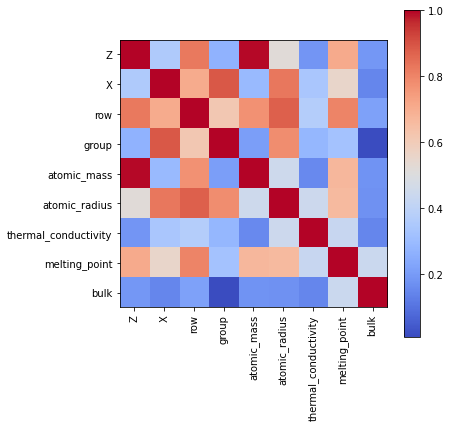

In [23]:
test_df = X.copy()
test_df[pred_val] = y
test_df

corr_matrix = test_df.corr()

plt.figure(figsize=(6,6))
plt.imshow(corr_matrix, cmap='coolwarm')
plt.colorbar()  # add color intensity map

plt.xticks(rotation=90)

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(range(len(corr_matrix)), corr_matrix.index)
plt.show()

Диаграмма корреляций прогнозируемой величины с величинами из набора векторов признаков:

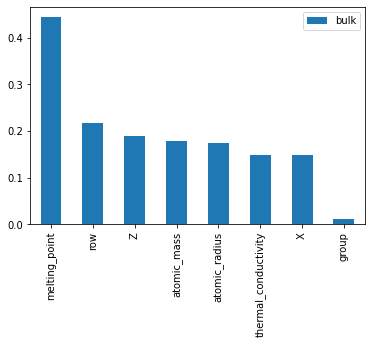

In [24]:
data_4_analysis = pd.DataFrame().append(X)
data_4_analysis[pred_val] = y

# bar plot
pd.DataFrame(data_4_analysis.corr()[pred_val]).\
             drop(index=[pred_val]).\
             sort_values(by=[pred_val], ascending=False).\
             plot(kind='bar')
plt.show()

---

# Regression models

Regression metric:

In [25]:
scoring='neg_mean_absolute_error'

*Other regression metrics from sklearn:*
- `explained_variance`
- `max_error`
- `neg_mean_absolute_error`
- `neg_mean_squared_error`
- `neg_root_mean_squared_error`
- `neg_mean_squared_log_error`
- `neg_median_absolute_error`
- `r2`
- `neg_mean_poisson_deviance`
- `neg_mean_gamma_deviance`
- `neg_mean_absolute_percentage_error`

In [26]:
res_table = pd.DataFrame()
tmp={}

## Linear regression

Cooresponding libraries

In [27]:
from sklearn.linear_model import LinearRegression

Функция построения графика $y_{pred}=f(y_{true})$ и отображения метрики $R^2$ в кросс-валидации:

In [28]:
def ex_plot(model_name, y_true, y_pred, scores):
    fig, ax = plt.subplots(figsize=(6,6))
    
    plt.plot(y_test, y_pred, 'o', label=str(scoring)+'(C-V) = '+str(round(scores,2)))
    
    max_dimension = max(y_test.max(), y_pred.max())
    min_dimension = min(y_test.min(), y_pred.min())
    
    x_line = [min_dimension, max_dimension]
    y_line = x_line
    
    plt.plot(x_line, y_line)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.legend()
    plt.title(model_name)
    
    plt.show()

---

Применение модели линейной регрессии:

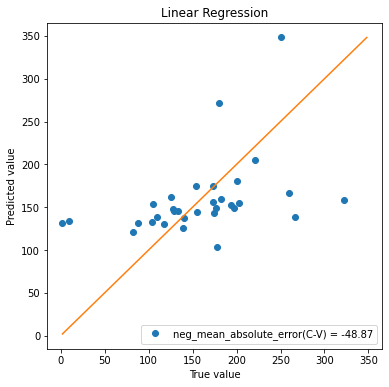

In [29]:
lr = LinearRegression()

''' MODEL FIT '''
lr.fit(X_train, y_train)
   
''' Cross-Validation '''
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring=scoring)

''' PLOT '''
ex_plot('Linear Regression', y_test, lr.predict(X_test), scores.mean())

tmp['model'] = 'lr'
tmp[scoring] = scores.mean()
res_table = res_table.append([tmp])

---

## kNN

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'n_neighbors': 2}


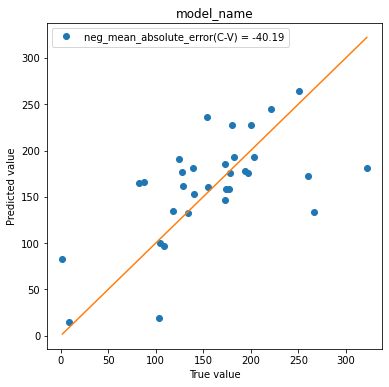

In [30]:
# Загрузка библиотек
from sklearn.neighbors import KNeighborsRegressor

# Инициализация модели МО:
model_knr = KNeighborsRegressor()

# Массив числа соседей для перебора
n_neighbors = np.arange(1,15,1) # from 1 to 10

# Определение сетки параметров
param_grid = {'n_neighbors': n_neighbors}

# Инициирование поиска по сетке параметров
gs = GridSearchCV(model_knr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)

# Определение наилучшей параметризации
model_best = gs.best_estimator_ 
print(gs.best_params_)
ex_plot('model_name', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())

In [31]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
knn_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'knn'
tmp[scoring] = knn_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## SVM

Fitting 5 folds for each of 192 candidates, totalling 960 fits
{'C': 1000, 'degree': 1, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.001}


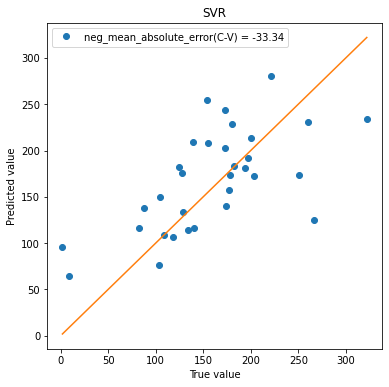

In [32]:
# Загрузка библиотек
from sklearn.svm import SVR

# Инициализация модели МО:
svr = SVR()

# Массив параметров для перебора
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [1,2,3,5]
tol = [0.001, 0.01]
C = [100, 1000]
epsilon = [0.2, 0.3, 0.5]

param_grid = {'kernel': kernel, 'degree' : degree, 'tol' : tol, 'C' : C, 'epsilon' : epsilon}

gs = GridSearchCV(svr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)
model_best = gs.best_estimator_
print(gs.best_params_)
ex_plot('SVR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').max())

In [33]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
svm_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'svm'
tmp[scoring] = svm_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## RFR

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'bootstrap': True, 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.0001, 'n_estimators': 300}


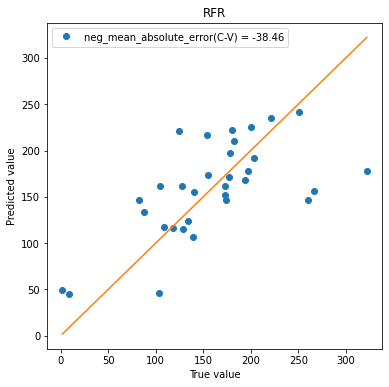

In [34]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor()

n_estimators = [300,500]
max_features = ['auto']
max_depth = [1,40,100]
min_samples_split = [0.0001,0.001,0.01]
min_samples_leaf = [1,2]
bootstrap = [True]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gs = GridSearchCV(RFR, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)

model_best = gs.best_estimator_
print(gs.best_params_)
ex_plot('RFR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())

In [35]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
rfr_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'rfr'
tmp[scoring] = rfr_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## GBR

Fitting 5 folds for each of 108 candidates, totalling 540 fits
------------------------------
Параметры наилучшего варианта:
{'learning_rate': 0.01, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 300}


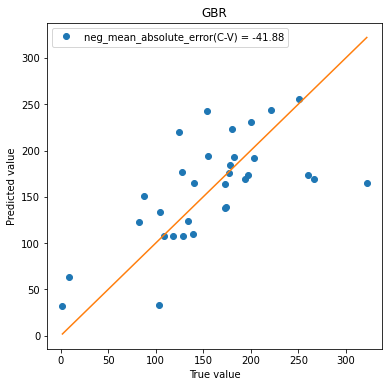

------------------------------


In [36]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

# Массивы значений параметров для поиска по сетке
learning_rate = [0.001, 0.01, 0.1]
n_estimators = [300,350]
min_samples_split = [0.001,0.01, 0.1]
min_samples_leaf = [1,2]
max_depth = [1,5,15]

param_grid = { 'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_depth': max_depth}

gs = GridSearchCV(gbr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)
model_best = gs.best_estimator_
print("------------------------------")
print("Параметры наилучшего варианта:")
print(gs.best_params_)
ex_plot('GBR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())
print("------------------------------")

In [37]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
gbr_res = results.sort_values(by='rank').set_index('rank').head(3)

tmp['model'] = 'gbr'
tmp[scoring] = gbr_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

## Simple regressors summary

In [38]:
res_table

,model,neg_mean_absolute_error
0,lr,-48.872694
0,knn,-37.177231
0,svm,-33.339281
0,rfr,-33.053635
0,gbr,-33.740883


---

# Keras model

In [39]:
# pre-requirements
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

# keras-tuner (general)
import tensorflow.keras as keras

# hyperparameter optimization algorithm
from kerastuner import Hyperband # OTHER MODULES: RandomSearch, BayesianOptimization

# easy calling
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters

## Keras tuner part

In [40]:
inputdim = X.shape[1]

def build_model(hp):
    
    ''' trial parameters '''
    # model type selection
    model = Sequential()
        
    # model hyperparameters
    activation_choice = hp.Choice('activation', values=['relu', 'sigmoid'])
    optimizer_choice = hp.Choice('optimizer', values=['adam','rmsprop','SGD'])
    hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) 
    
    ''' ANN STRUCTURE '''
    # first h-layer
    model.add(Dense(units=hp.Int('layer_1', min_value=20, max_value=200, step=20),
                    input_dim=inputdim,
                    activation=activation_choice))
    
    # other h-layer 
    # optimized for perfomance
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(Dense(units=hp.Int('layer_' + str(i), min_value=20, max_value=100, step=20),
                        activation=activation_choice))
    
    # output layer
    model.add(Dense(1))
    
    ''' instantiate ANN '''
    model.compile(optimizer=optimizer_choice,
                  loss='MAE',
                  metrics=['MAE'])
    return model

In [41]:
tuner = Hyperband(build_model,
                  objective='val_MAE',
                  max_epochs=500, # for Hyperband only
                  #max_trials=20, # for BayesianOptimization & RandomSearch
                  directory='test_dir') #, # ATTENTION! path should be latin!!!!!!
                  #overwrite=True) # overwrite all previous models in specified directory

INFO:tensorflow:Reloading Oracle from existing project test_dir\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from test_dir\untitled_project\tuner0.json


In [42]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'SGD'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 20, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': None}
layer_0 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 100, 'step': 20, 'sampling': None}
layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 100, 'step': 20, 'sampling': None}
layer_3 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 100, 'step': 20, 'sampling': None}


In [43]:
tuner.search(X_train, y_train, 
             batch_size=200, # optimal batch size preselected
             # epochs=500,   # for BayesianOptimization & RandomSearch
             validation_split=0.2,
             verbose=2)

Trial 310 Complete [00h 01m 28s]
val_MAE: 144.69534301757812

Best val_MAE So Far: 50.203983306884766
Total elapsed time: 00h 42m 08s
INFO:tensorflow:Oracle triggered exit


In [44]:
tuner.results_summary()

Results summary
Results in test_dir\untitled_project
Showing 10 best trials
Objective(name='val_MAE', direction='min')
Trial summary
Hyperparameters:
activation: relu
optimizer: rmsprop
learning_rate: 0.01
layer_1: 200
num_layers: 2
layer_0: 40
layer_2: 40
layer_3: 100
tuner/epochs: 500
tuner/initial_epoch: 167
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: bfa2a9a6dbecf7535773be74778706c8
Score: 50.203983306884766
Trial summary
Hyperparameters:
activation: relu
optimizer: rmsprop
learning_rate: 0.0001
layer_1: 200
num_layers: 3
layer_0: 40
layer_2: 60
layer_3: 100
tuner/epochs: 500
tuner/initial_epoch: 167
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 924d310925b70f6aa740042d0fa0e1fc
Score: 50.266475677490234
Trial summary
Hyperparameters:
activation: relu
optimizer: rmsprop
learning_rate: 0.01
layer_1: 160
num_layers: 3
layer_0: 80
layer_2: 80
layer_3: 20
tuner/epochs: 167
tuner/initial_epoch: 56
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: e080bb6ad2272799321f1dbac860d4c7
Scor

## Get best models

In [57]:
models = tuner.get_best_models(num_models=3)

In [58]:
m1 = models[0]
m2 = models[1]
m3 = models[2]
m1.fit(X_train, y_train)
m2.fit(X_train, y_train)
m3.fit(X_train, y_train)

4/4 [==============================] - 1s 2ms/step - loss: 49.2319 - MAE: 49.2319


In [59]:
m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1800      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                8040      
_________________________________________________________________
dense_2 (Dense)              (None, 200)               8200      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


In [60]:
m2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1800      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                8040      
_________________________________________________________________
dense_2 (Dense)              (None, 200)               8200      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                12060     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total params: 30,161
Trainable params: 30,161
Non-trainable params: 0
_________________________________________________________________


In [61]:
m3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160)               1440      
_________________________________________________________________
dense_1 (Dense)              (None, 80)                12880     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               12960     
_________________________________________________________________
dense_3 (Dense)              (None, 80)                12880     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 81        
Total params: 40,241
Trainable params: 40,241
Non-trainable params: 0
_________________________________________________________________


## Best models validation

- [Basics on Keras models](https://habr.com/ru/post/485890/)

In [124]:
from sklearn.metrics import mean_absolute_error

def get_X_y(df_test, df_train):    
    X_train = df_train.copy().drop([pred_val], axis='columns')
    y_train = pd.DataFrame(df_train[pred_val])
    X_test = df_test.copy().drop([pred_val], axis='columns')
    y_test = pd.DataFrame(df_test[pred_val])
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, y_train, X_test, y_test
    
def get_predictions(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=100, verbose=0)
    predicticted_values = model(X_test).numpy()
    predicticted_values = predicticted_values.reshape(predicticted_values.shape[0]) 
    mae = mean_absolute_error(y_test, predicticted_values) 
    return mae

In [127]:
from sklearn.model_selection import KFold

ad = X.copy()
ad['bulk'] = y

# splits number for k-fold C-V
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)

# instantiate the progress indication
progress = 0
max_progress = n_splits

# temporary data for futher plotting
hist = pd.DataFrame()
tmp = {}

for train, test in kf.split(ad):
    new_model = m1
    df_train = ad.iloc[train]
    df_test = ad.iloc[test]
    X_train, y_train, X_test, y_test = get_X_y(df_test, df_train)
    mae = get_predictions(new_model, X_train, y_train, X_test, y_test)
    tmp['Fold'] = progress
    tmp['mae'] = mae
    hist = hist.append([tmp])
    
    # progress update
    progress += 1
    print(f'Progress: {progress}/{max_progress}', end='\r')

hist = hist.set_index(['Fold'])

The volumes ratio of training/test samples: 128/32
4/4 [==============================] - 0s 3ms/step - loss: 20.8925 - MAE: 20.8925


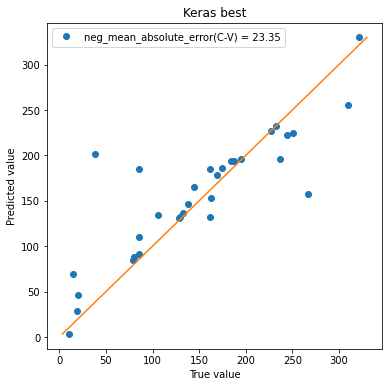

In [131]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_1 = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=test_size)
print("The volumes ratio of training/test samples: "+str(X_train.shape[0])+'/'+str(X_test.shape[0]))

m1.fit(X_train, y_train)
y_pred =  m1.predict(X_test)
ex_plot('Keras best', y_test, y_pred, hist.mae.mean())

## Save whole model

In [133]:
m1.save('keras_best_model.h5')

In [53]:
# model = keras.models.load_model('best_model.h5')
# model.fit(X_train, y_train, epochs=200)
# predicticted_values = model(X_test).numpy()
# predicticted_values = predicticted_values.reshape(predicticted_values.shape[0])

In [54]:
# plt.plot(y_test, predicticted_values, 'bo')

In [56]:
# # Восстановим в точности ту же модель, включая веса и оптимизатор
# new_model = keras.models.load_model('best_model.h5')

# # Покажем архитектуру модели
# new_model.summary()

# plot_model_fit(new_model, X_test, y_test)

# Models comparison

In [148]:
res_table[scoring] = res_table[scoring].apply(lambda x: abs(x))
res_table = res_table.reset_index().drop(['index'], axis=1)
res_table = res_table.append({'model':'Keras', scoring:hist.mae.mean()}, ignore_index=True)

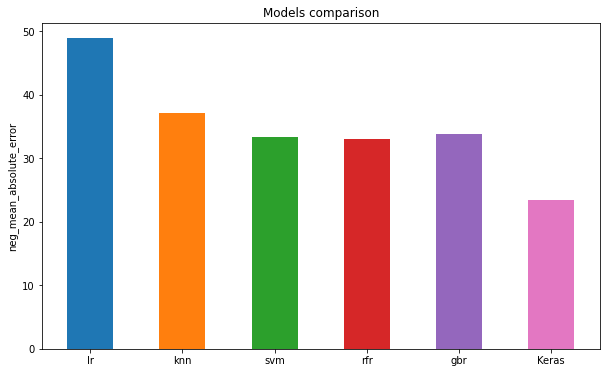

In [153]:
fig, ax = plt.subplots(figsize=(10,6))

for idx in res_table.index:
    plt.bar(res_table.loc[idx].model,res_table.loc[idx][scoring],width=0.5)

plt.ylabel(scoring)
plt.title('Models comparison')

plt.show()

## Alternative plot

In [165]:
res_table[scoring].max()
res_table[scoring].min()

23.349094320833682

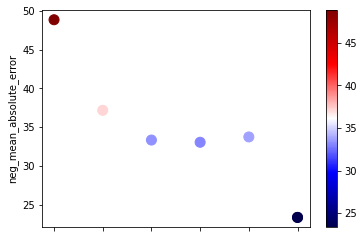

In [187]:
res_table.plot.scatter(x='model', y=scoring, c=res_table[scoring], colormap='seismic', s=100) ; plt.show()